In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv
import skimage
from skimage import data, io, filters, exposure
from skimage.color import rgb2gray
from skimage import feature
from skimage import measure
import random as rng

from dice_counter import *

## Wkyrywanie liczby oczek w kostkach 
### Piotr Derenowski
### Mateusz Klaczyński 

Celem projektu jest stworzenie programu wykrywającego liczbę widocznych oczek na zdjęciach kostek do gry. Po znalezieniu takowej, program sprawdza ile oczek ma widoczna ściana kostki i wypisuje liczbę oczek obok miejsca wykrycia. Następnie, po sprawdzeniu wszystkich kostek, wypisuje liczbę wszystkich oczek w lewym górnym rogu obrazka. Projekt oparty jest na bibliotece języka python - openCV. 

Poniżej przedstawione zostało przykładowe przetwarzanie obrazka, z opisem krok po kroku wykonywanych przez program operacji.

Na samym końcu raportu znajduje się prezentacja działania programu na większej ilości różnych zdjęć.

1. Proces wykrywania zaczynam od wczytania zdjęcia biblioteką opencv zmianie rozdzielczości zdjęcia oraz nałożenia filtra szarości na zdjęcie  

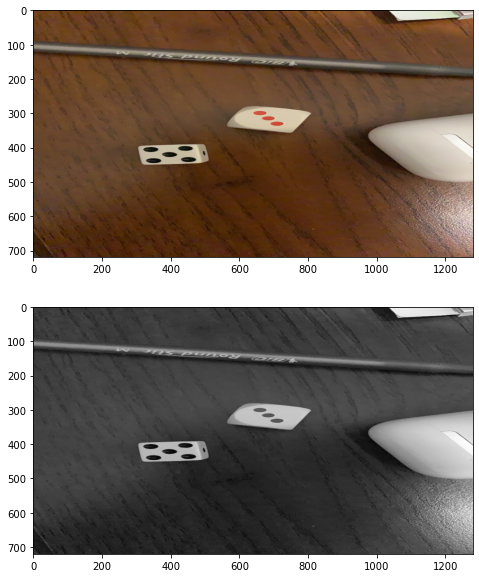

In [2]:
image = cv.imread("1.jpg")
image = cv.resize(image, (1280, 720))
bw_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 1, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
fig.add_subplot(2, 1, 2)
plt.imshow(bw_image, cmap="binary_r")
plt.show()

2. Definujemy funkcję która usuwa ze zdjęcia wszystko co jest poniżej średniej + mediany wartości pikseli zdjęcia 

In [3]:
def remove_everything_below_std_and_mean(image):
    treshold = round(np.std(image) + np.mean(image))
    return np.array((image > treshold) * 255, dtype=np.uint8)

Efekt funkcji 

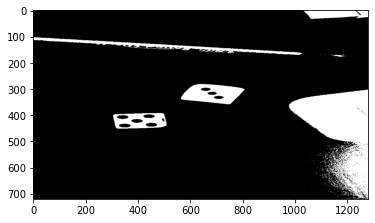

In [4]:
filtered = remove_everything_below_std_and_mean(bw_image)
plt.imshow(filtered, cmap="binary_r")
plt.show()

Następnie używamy wbudowanej w opencv funkcji erode by powiększyć miejsca zaineteresowania pozbyć się szumu który występuje obok siebie, nakładamy dwie iteracje

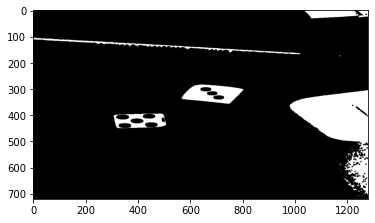

In [5]:
kernel = np.ones((3,3), np.uint8)
eroded = cv.erode(filtered, kernel, iterations=2)
plt.imshow(eroded, cmap="binary_r")
plt.show()

In [6]:
def process(base_image, filtered_image):
    base_image = np.array(base_image, dtype=np.uint8)
    min_width = 30
    max_width = 400
    rectangle_thickness = 4
    color = (rng.randint(120,130), rng.randint(120,130), rng.randint(120,130))
    minimum_distance_between_circles_centers = 80 

    contoursss, hierarchy = cv.findContours(filtered_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    all_circles = 0

    for j, con in enumerate(contoursss):
        x,y,w,h = cv.boundingRect(contoursss[j])

        perimeter  = cv.arcLength(con, True)
        approx = cv.approxPolyDP(con, 0.03 * perimeter , True)
        
        if len(approx) != 4 or w < min_width or w > max_width or h < min_width or h > max_width:
            continue

        cropped =  filtered_image[y:y+h,x:x+w]
        rezised = cv.resize(cropped, (400, 400))

        circles = cv.HoughCircles(rezised, cv.HOUGH_GRADIENT, 1,
                            minimum_distance_between_circles_centers,
                            param1=100, param2=14,
                            minRadius=15, maxRadius=80)

        if circles is None:
            continue 

        circles = np.uint16(np.around(circles))
        circles_count = len(circles[0, :])
        all_circles += circles_count
        cv.rectangle(base_image, (x, y), (x+w, y+h), color, rectangle_thickness)
        cv.putText(base_image, str(circles_count), (x+w+10, y+h+10), cv.FONT_HERSHEY_SIMPLEX, 2, color, 3, cv.LINE_AA)

    cv.putText(base_image, f'Wszystkich kropek: {all_circles}', (60, 60), cv.FONT_HERSHEY_SIMPLEX, 2, (100, 100, 100), 4, cv.LINE_AA)
    

    plt.imshow(cv.cvtColor(base_image, cv.COLOR_BGR2RGB))

    plt.show()


Efektem funkcji jest

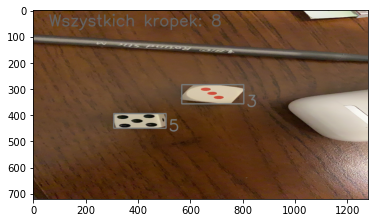

In [7]:
process(image, eroded)

```

Poszukujemy konturów zdefiniowaną przez openCV funkcją `findContours`, z parametrem `cv.RETR_EXTERNAL` który zwróci nam tylko zewnętrzne kontury
```python
contoursss, hierarchy = cv.findContours(filtered_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
```
Następnie iterujemy po wszystkich znalezionych konturach, i wyznaczamy najmniejszy prostokąt otaczający dany kontur 
```python
for j, con in enumerate(contoursss):
    x,y,w,h = cv.boundingRect(contoursss[j])   
```
przy pomocy funkcji `arcLength` i `approxPolyDP` wyznaczamy przybliżoną ilość kątów jeśli liczba kątów jest inna niż 4 to omijamy dany kontur, także jeśli szerokośc i wysokość nie jest w empirycznie wyznaczonym przedziale omijamy kontur 
```python
    perimeter  = cv.arcLength(con, True)
    approx = cv.approxPolyDP(con, 0.03 * perimeter , True)
    
    if len(approx) != 4 or w < min_width or w > max_width or h < min_width or h > max_width:
        continue
```
jeśli kontur spełnił wszystkie warunki to wycinamy ten frgment zdjęcia według wcześniej wyznaczonego najmniejszego prostokąta otaczającego kontur i zmieniamy rozdzielczość do stałego rozmiaru po to żeby łatwiej było dobrać parametry do funkcji `HoughCircles`
```python
        cropped =  filtered_image[y:y+h,x:x+w]
        rezised = cv.resize(cropped, (400, 400))
```
funkcja `HoughCircles` znajduje na obrazku kontury w kształcie kół,  jako  parametry przyjmuje po kolei nasz fragment zdjęcia, metodę z jaką określa kontury, mnożnik rozdzielczości akumulatora to metody określającej kontury, następnie podawny jest minimalny dystant jaki przyjmujemy między środkami kół, oraz kolejne dwa parametry `param1` przekazywane do Canny detektora konturó i `param2` który odpowiada za "jakoś" kół im mniejsza jego wartośc tym dopuszcamy bardziej zniekształcone koła, następnie dwa samo defuniujące się parametry `minRadius` i `maxRadius`.  
Wartości jakie używamy zostały wybrane empirycznie

```python
        circles = cv.HoughCircles(rezised, cv.HOUGH_GRADIENT, 1,
                            minimum_distance_between_circles_centers,
                            param1=100, param2=14,
                            minRadius=15, maxRadius=80)
```

Jeśli na danym fragmencie zdjęć nie zostało wykryte żadne koło to omijamy ten fragment.  
Jesli zostało wykryte kropki to do wszystkich kropek dodajemy ilość kropek na fragmencie oraz rysujemy otaczający go prostokąt i liczbę kropek na danej kostce
```python
        if circles is None:
                    continue 

                circles = np.uint16(np.around(circles))
                circles_count = len(circles[0, :])
                all_circles += circles_count
                cv.rectangle(base_image, (x, y), (x+w, y+h), color, rectangle_thickness)
                cv.putText(base_image, str(circles_count), (x+w+10, y+h+10), cv.FONT_HERSHEY_SIMPLEX, 2, color, 3, cv.LINE_AA)

```

efekt podziału na obrazka na fragmenty można zobaczyć poniżej, dla przejrzystoći użyłem funkcji z pliku `dices_counter.py` gdzie zdefiniowałem funkcję bardzo podobną do wyżej pokazanej `process`

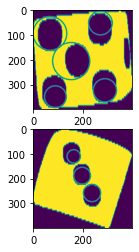

In [8]:
process_image_and_draw_fragments(eroded)

Przykład naszego algorytmu można zobaczyć na poniższych przykładach

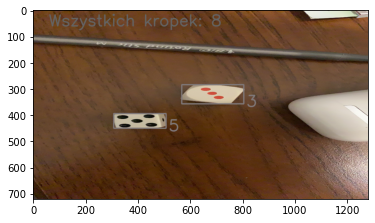

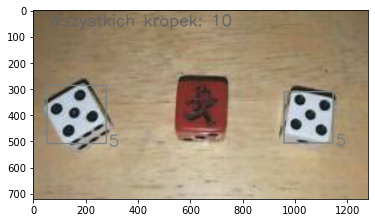

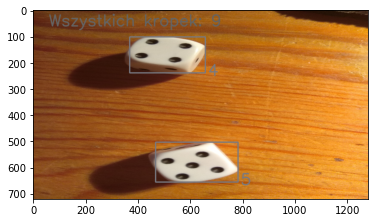

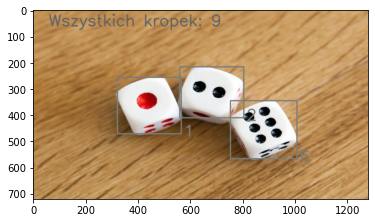

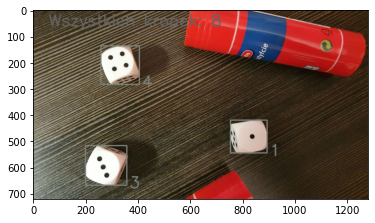

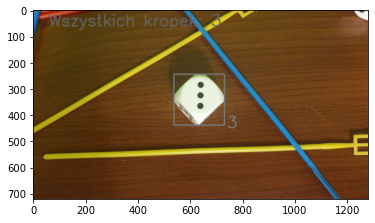

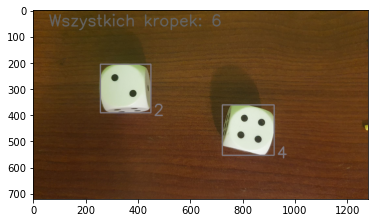

In [9]:
for i in range(1,8):
    process_image(f"{i}.jpg")